# Road Perception

Perception is an integral component of any form of robot or autonomous vehicle system, including the systems that may be used in an embodied agent. This project demonstrates some perception techniques that could be used in a road setting.

## What is it?

Given an image showing the front camera view from a car on a road, this project detects the road lane markings and other cars, then identifies the next car in the current lane. This information has several applications; for example, it could be used to tell the robot whether it is too close, too far or at an appropriate distance from the vehicle in front. Alternatively, the lane markings could also be used to follow a given trajectory or determine whether or not the car is drifting out of lane.

## How does it work?

Two models from Hugging Face are used: [TwinLiteNetPlus](https://huggingface.co/nielsr/twinlitenetplus-nano) for lane detection, and [RT-DETRv2](https://huggingface.co/PekingU/rtdetr_v2_r101vd) for object detection. TwinLiteNetPlus is a very lightweight model that can produce binary segmentation masks for lane markers, which are further preprocessed in this project. RT-DETRv2 is a robust transformer-based object detection model, which has the advantage of not requiring non-maximum suppression (NMS), unlike the YOLO family of models. Both of these models feature real-time performance characteristics, making them suitable for robots and an embodied agent.

The lane detection pipeline works first by finding contours in the segmentation map to find the centroids of the keypoints on the lanes. Then, cubic splines are fitted to these points both to remove noise by smoothing out the results and also to interpolate gaps in between keypoints. To identify individual lane markings, the angle between the line drawn from a keypoint to the vanishing point (which all lane lines converge towards) and the horizontal is taken, since this identifies which lane marking the keypoint belongs to. Then, a simple algorithm is used to "cluster" the points before interpolation.

To identify the next car in the lane, RT-DETRv2 is used to detect car objects, returning their bounding boxes. The bottom-center point on the bounding box is taken. Using the left and right lane marker identified through lane detection, the objects are filtered for whether or not they are in the same lane as the ego vehicle, and finally the nearest car is taken.

## How to run it?

Install dependencies:

```bash
pip install -r requirements.txt
```

Run the code in this Jupyter Notebook.

Notes:
- This code was developed and tested using Python 3.13.
- It is also possible to use the uv package manager to manage dependencies.

## Model Loading and Initialization

This cell loads two pre-trained models: TwinLiteNetPlus for lane detection/segmentation and RT-DETRv2 for object detection. The lane model is downloaded from Hugging Face Hub and uses safetensors format for efficient loading. RT-DETRv2 is loaded directly from the transformers library with its corresponding image processor for input preprocessing.

In [14]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file
from transformers import RTDetrImageProcessor, RTDetrV2ForObjectDetection
from twinlitenetplus import TwinLiteNetPlus


def load_lane_model():
    model_path = hf_hub_download(
        repo_id="nielsr/twinlitenetplus-nano", filename="model.safetensors"
    )
    print(f"Model downloaded to: {model_path}")

    model_state_dict = load_file(model_path)
    print(f"Model contains {len(model_state_dict)} parameters")

    model = TwinLiteNetPlus()
    model.load_state_dict(model_state_dict)

    return model


def load_object_detection_model():
    image_processor = RTDetrImageProcessor.from_pretrained("PekingU/rtdetr_v2_r101vd")
    model = RTDetrV2ForObjectDetection.from_pretrained("PekingU/rtdetr_v2_r101vd")
    return model, image_processor


print("Loading lane model...")
lane_detector = load_lane_model()

print("Loading object detection model...")
object_detector, object_processor = load_object_detection_model()

Loading lane model...
Model downloaded to: /home/isaac/.cache/huggingface/hub/models--nielsr--twinlitenetplus-nano/snapshots/bce554020275d4f45bcce923115304c4e946b42c/model.safetensors
Model contains 228 parameters
Loading object detection model...


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 8830.11it/s]


## Image Loading and Display
Loads the demo image from the images directory and displays it. OpenCV loads images in BGR format, so cv2.cvtColor converts it to RGB for proper matplotlib display. This serves as our input for the perception pipeline.

Original image shape: (1080, 1920, 3)


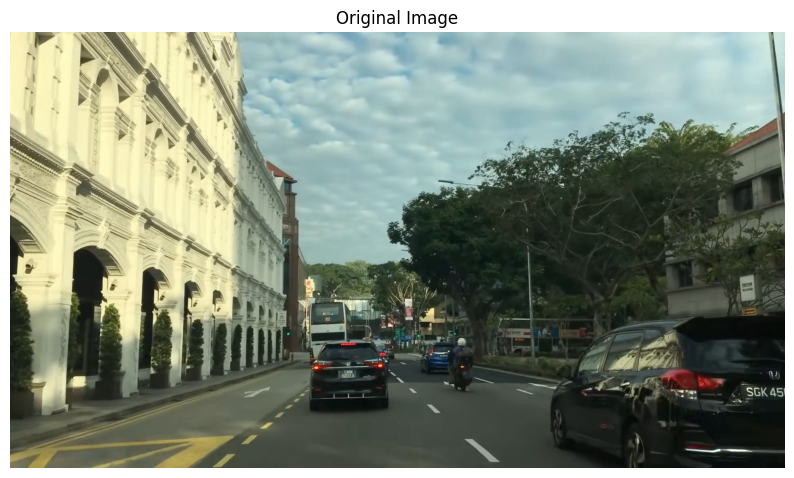

In [ ]:
img_path = "images/demo.jpg"
img_orig = cv2.imread(img_path)
assert img_orig is not None, f"Could not load image from {img_path}"
print(f"Original image shape: {img_orig.shape}")

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
plt.show()

## Image Preprocessing for Lane Detection
The letterbox preprocessing function (adapted from TwinLiteNetPlus repo) resizes images while maintaining aspect ratio using padding. It ensures consistent 640x640 input size required by the lane detection model while preserving spatial relationships.

In [16]:
from twinlitenetplus import letterbox_for_img, show_seg_result

img_processed_lane, ratio, (dw, dh) = letterbox_for_img(
    img_orig, new_shape=(640, 640), auto=True
)
h, w = img_processed_lane.shape[:2]

img_rgb = cv2.cvtColor(img_processed_lane, cv2.COLOR_BGR2RGB)
img_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

print(f"Processed image shape: {img_processed_lane.shape}")
print(f"Tensor shape: {img_tensor.shape}")

Processed image shape: (384, 640, 3)
Tensor shape: torch.Size([1, 3, 384, 640])


## Lane Detection Inference
Runs the TwinLiteNetPlus model on the preprocessed image to generate two segmentation masks: drivable area and lane lines. The model outputs are post-processed by removing padding, interpolating back to original size, and applying argmax to get final binary masks. This produces pixel-level predictions for road structure.

In [17]:
lane_detector.eval()

with torch.no_grad():
    da_seg_out, ll_seg_out = lane_detector(img_tensor)

    print(f"Drivable area output shape: {da_seg_out.shape}")
    print(f"Lane line output shape: {ll_seg_out.shape}")

    _, _, height, width = img_tensor.shape
    h_orig, w_orig = img_orig.shape[:2]

    pad_w = int(dw)
    pad_h = int(dh)

    da_predict = da_seg_out[:, :, pad_h : (height - pad_h), pad_w : (width - pad_w)]
    da_seg_mask = torch.nn.functional.interpolate(
        da_predict, scale_factor=int(1 / ratio[0]), mode="bilinear"
    )
    _, da_seg_mask = torch.max(da_seg_mask, 1)
    da_seg_mask = da_seg_mask.int().squeeze().cpu().numpy()

    ll_predict = ll_seg_out[:, :, pad_h : (height - pad_h), pad_w : (width - pad_w)]
    lane_mask = torch.nn.functional.interpolate(
        ll_predict, scale_factor=int(1 / ratio[0]), mode="bilinear"
    )
    _, lane_mask = torch.max(lane_mask, 1)
    lane_mask = lane_mask.int().squeeze().cpu().numpy()


Drivable area output shape: torch.Size([1, 2, 384, 640])
Lane line output shape: torch.Size([1, 2, 384, 640])


## Object Detection with RT-DETRv2
Runs object detection on the original image using RT-DETRv2. The image processor handles preprocessing, the model generates predictions, and post-processing converts outputs to bounding boxes with confidence scores above 0.5 threshold. Results are visualized with green bounding boxes and labels showing detected objects and confidence scores.

Detected car with confidence 0.96 at [1334  698 1919 1075]
Detected car with confidence 0.93 at [739 762 942 938]
Detected car with confidence 0.87 at [1013  769 1101  847]
Detected person with confidence 0.87 at [1083  756 1147  888]
Detected pottedplant with confidence 0.78 at [344 689 406 883]
Detected bus with confidence 0.73 at [735 666 841 808]
Detected pottedplant with confidence 0.72 at [213 671 286 910]
Detected pottedplant with confidence 0.64 at [  0 604  64 959]
Detected pottedplant with confidence 0.62 at [499 720 539 852]
Detected motorbike with confidence 0.57 at [1092  822 1144  890]
Detected pottedplant with confidence 0.57 at [426 708 484 865]


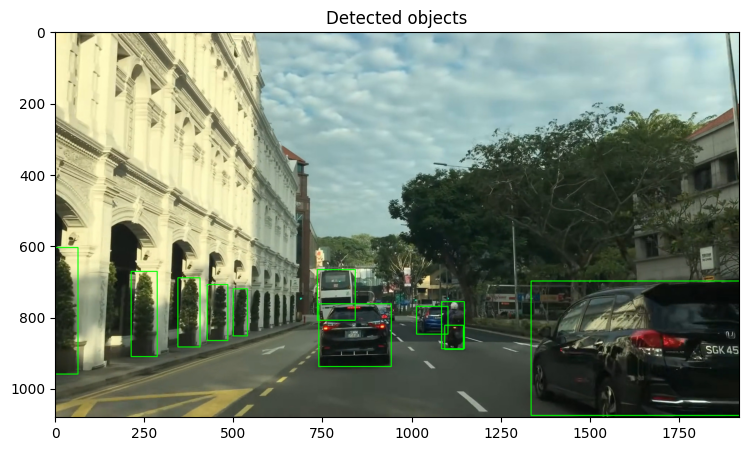

In [18]:
inputs = object_processor(images=img_orig, return_tensors="pt")

with torch.no_grad():
    outputs = object_detector(**inputs)

height, width = img_orig.shape[:2]
detections = object_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(height, width)]), threshold=0.5
)[0]

annotated = img_orig.copy()
for score, label_id, box in zip(
    detections["scores"], detections["labels"], detections["boxes"]
):
    box = box.cpu().numpy().astype(int)
    label = object_detector.config.id2label[label_id.item()]
    score = score.item()
    print(f"Detected {label} with confidence {score:.2f} at {box}")

    # Draw bounding box and label on the image
    annotated = cv2.rectangle(
        annotated, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2
    )

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.title("Detected objects")
plt.show()

## Segmentation Results Visualization
Creates a comprehensive visualization grid showing original image, individual masks (drivable area and lane lines), combined overlay, and separate overlays. Uses color coding: green for drivable areas, red for lane lines. This provides multiple views of the segmentation results for analysis and validation.

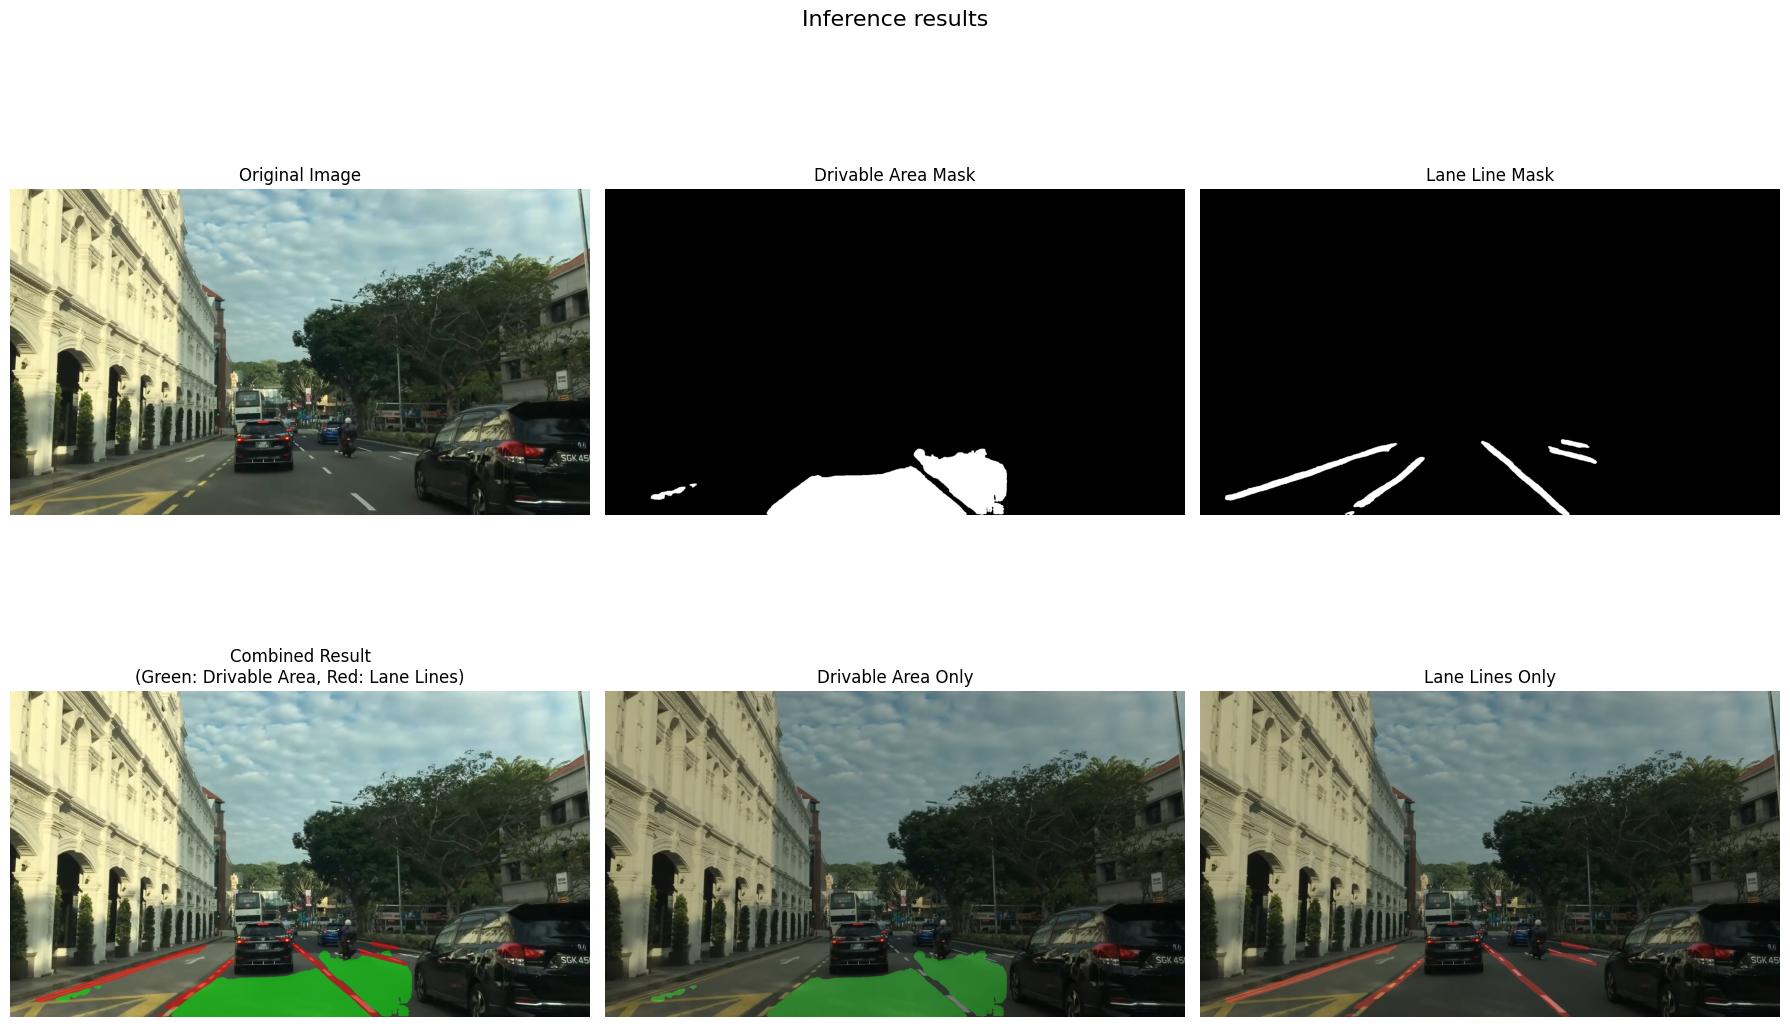

In [19]:
result_img = show_seg_result(img_orig, da_seg_mask, lane_mask)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Inference results", fontsize=16)

# Original image
axes[0, 0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

# Drivable area mask
axes[0, 1].imshow(da_seg_mask, cmap="gray")
axes[0, 1].set_title("Drivable Area Mask")
axes[0, 1].axis("off")

# Lane line mask
axes[0, 2].imshow(lane_mask, cmap="gray")
axes[0, 2].set_title("Lane Line Mask")
axes[0, 2].axis("off")

# Combined result
axes[1, 0].imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title("Combined Result\n(Green: Drivable Area, Red: Lane Lines)")
axes[1, 0].axis("off")

# Drivable area overlay only
da_only_img = img_orig.copy()
da_overlay = np.zeros_like(img_orig)
da_overlay[da_seg_mask == 1] = [0, 255, 0]
da_only_result = cv2.addWeighted(da_only_img, 0.7, da_overlay, 0.3, 0)
axes[1, 1].imshow(cv2.cvtColor(da_only_result, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title("Drivable Area Only")
axes[1, 1].axis("off")

# Lane line overlay only
ll_only_img = img_orig.copy()
ll_overlay = np.zeros_like(img_orig)
ll_overlay[lane_mask == 1] = [0, 0, 255]
ll_only_result = cv2.addWeighted(ll_only_img, 0.7, ll_overlay, 0.3, 0)
axes[1, 2].imshow(cv2.cvtColor(ll_only_result, cv2.COLOR_BGR2RGB))
axes[1, 2].set_title("Lane Lines Only")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

## Lane Marker Detection and Centroid Extraction
The first step of lane marker detection is to extract the keypoints of each lane marker from the raw binary segmentation mask. To do this, the binary mask is "sliced" at constant intervals, cutting it up into horizontal chunks. Then, contiguous regions known as contours are detected using computer vision algorithms (OpenCV contour detection). Finally, the centroid of each contour is taken as a keypoint.

In some cases, the binary segmentation mask may contain the horizontal stopping lines present on roads. These are removed by filtering contours with a high aspect ratio (width / height), using a threshold of 20 to ensure only lane keypoints are retained.

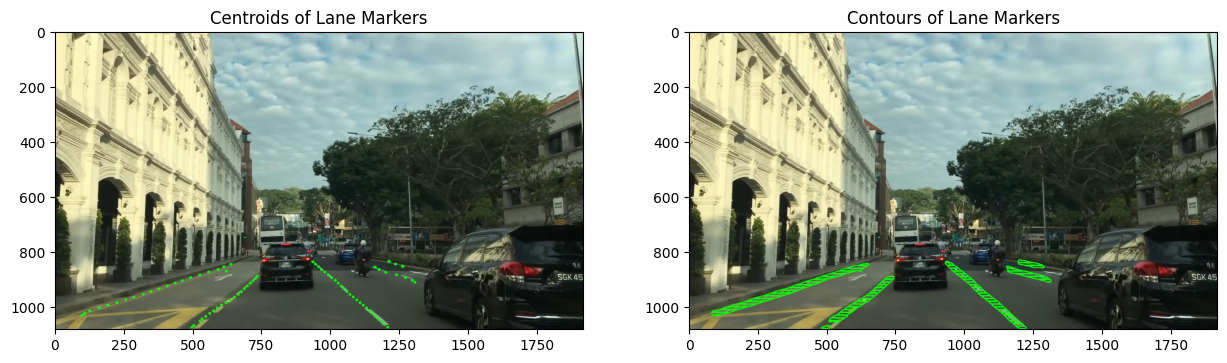

In [20]:
aspect_ratio_threshold = 20

lane_mask_sliced = lane_mask.copy()
lane_mask_sliced[1080 - 1 : 800 - 1 : -10, :] = 0

contours, _ = cv2.findContours(
    lane_mask_sliced, cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_SIMPLE
)
contours = [c for c in contours if cv2.boundingRect(c)[2] / cv2.boundingRect(c)[3] < 20]
bounding_rects = [cv2.boundingRect(c) for c in contours]
moments = [cv2.moments(c) for c in contours]
centroids = set(
    (int(m["m10"] / m["m00"]), int(m["m01"] / m["m00"]))
    for r, m in zip(bounding_rects, moments)
    if r[2] / r[3] <= aspect_ratio_threshold and m["m00"] != 0
)

annotated = img_orig.copy()
for c in centroids:
    cv2.circle(annotated, c, 5, (0, 255, 0), -1)

fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
ax[0].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
ax[0].set_title("Centroids of Lane Markers")
ax[1].imshow(
    cv2.cvtColor(
        cv2.drawContours(img_orig.copy(), contours, -1, (0, 255, 0), 2),
        cv2.COLOR_BGR2RGB,
    )
)
ax[1].set_title("Contours of Lane Markers")
plt.show()

## Vanishing Point Analysis and Angle Calculation
Defines the vanishing point manually based on camera perspective (where parallel lane lines converge). Calculates angles from each lane marker centroid to the vanishing point using arctangent. This geometric approach enables lane grouping based on perspective geometry principles, essential for distinguishing left/right lanes.

The angle-based approach works because each lane marker will have a unique angle towards the vanishing point, which enables us to cluster the keypoints into whole lane markers.

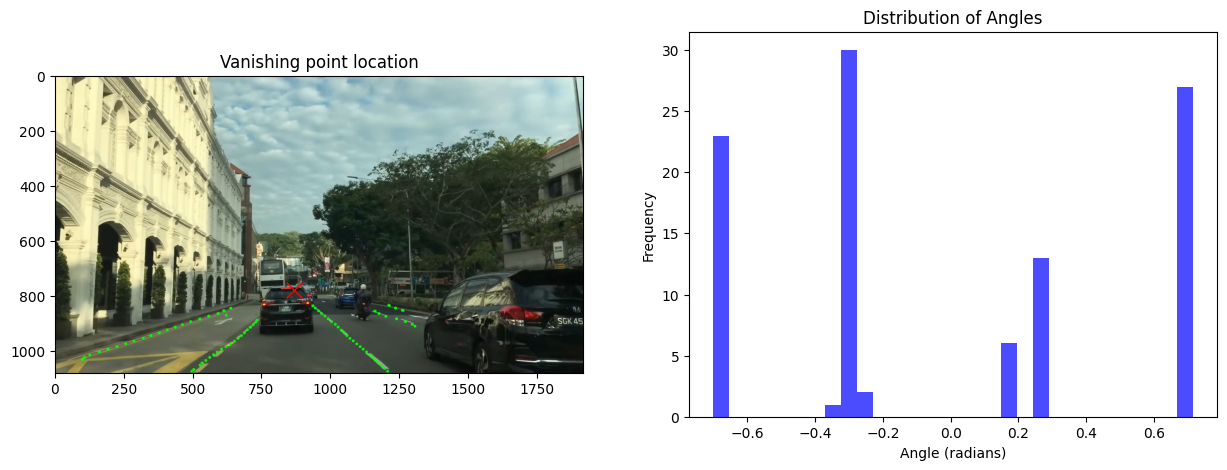

In [21]:
import math

# Set this individually based on the camera's perspective
vanishing_x, vanishing_y = 870, 780

centroids = sorted(
    centroids, key=lambda c: c[1], reverse=True
)  # Sorted by y-coordinate from bottom to top
angles = [math.atan((y - vanishing_y) / (x - vanishing_x)) for x, y in centroids]

# Plot location of vanishing point with lanes & distribution of angles
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
ax[0].plot(vanishing_x, vanishing_y, "rx", markersize=12)
ax[0].set_title("Vanishing point location")

ax[1].hist(angles, bins=30, color="blue", alpha=0.7)
ax[1].set_title("Distribution of Angles")
ax[1].set_xlabel("Angle (radians)")
ax[1].set_ylabel("Frequency")

plt.show()

## Angle-Based Lane Clustering
Groups lane markers by angle similarity using a 10-degree threshold. Markers with similar angles to the vanishing point likely belong to the same lane line. The clustering algorithm merges nearby angle groups and deduplicates markers at the same y-coordinate by averaging x-positions. This creates distinct lane line groups. Deduplication is necessary to run SciPy's interpolation functions.

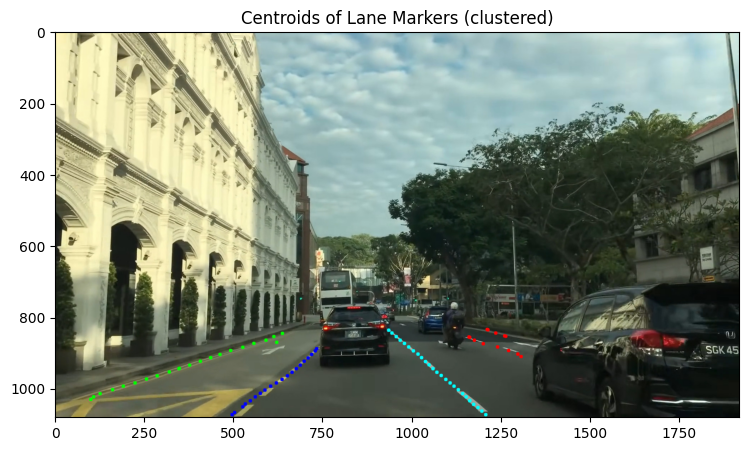

In [22]:
threshold = np.radians(10)

clusters = {}
for c, a in zip(centroids, angles):
    nearest_cluster = min(clusters.keys(), key=lambda c: abs(c - a), default=None)
    if nearest_cluster is None or abs(nearest_cluster - a) > threshold:
        clusters[a] = []
        nearest_cluster = a
    clusters[nearest_cluster].append((c, a))

    clusters = {
        sum(a for _, a in centroids) / len(centroids): centroids
        for centroids in clusters.values()
    }


def dedup_cluster(cluster):
    cluster_dedup = {}
    for (x, y), _ in cluster:
        if y in cluster:
            cluster_dedup[y] = (cluster_dedup[y] + x) // 2
        else:
            cluster_dedup[y] = x
    return list(sorted(((x, y) for y, x in cluster_dedup.items()), key=lambda c: c[1]))


clusters = {k: dedup_cluster(v) for k, v in clusters.items()}
clusters = dict(sorted(clusters.items()))

COLORS = [
    (255, 0, 0),
    (0, 255, 0),
    (0, 0, 255),
    (255, 255, 0),
    (255, 0, 255),
    (0, 255, 255),
]
annotated = img_orig.copy()
for i, cluster in enumerate(clusters.values()):
    for centroid in cluster:
        cv2.circle(annotated, centroid, 5, COLORS[i % len(COLORS)], -1)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.title("Centroids of Lane Markers (clustered)")
plt.show()

## Smooth Lane Curve Generation with Splines
Fits smooth spline curves through each cluster of lane markers using SciPy interpolation. Each cluster's x,y coordinates are interpolated with 300 sampling points to create smooth, continuous lane boundaries. This converts discrete marker points into mathematically smooth curves representing lane lines, using a parameter of `k=3` to perform a cubic polynomial fit.

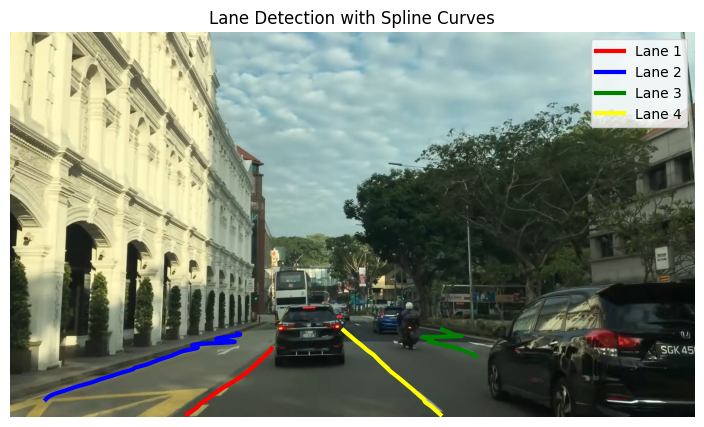

In [23]:
from scipy.interpolate import make_interp_spline

sampling_resolution = 300

splines = {}
for angle, cluster in clusters.items():
    x = np.array([c[0] for c in cluster])
    y = np.array([c[1] for c in cluster])
    ys = np.linspace(min(y), max(y), sampling_resolution)
    spline = make_interp_spline(y, x)
    xs = spline(ys)
    splines[angle] = (spline, xs, ys)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

COLORS = ["red", "blue", "green", "yellow", "cyan", "magenta"]
for i, (spline, xs, ys) in enumerate(splines.values()):
    plt.plot(xs, ys, COLORS[i % len(COLORS)], linewidth=3, label=f"Lane {i + 1}")

plt.title("Lane Detection with Spline Curves")
plt.legend()
plt.axis("off")
plt.show()

## Left and Right Lane Identification
Separates lanes into left and right based on their angles relative to the vanishing point. Negative angles indicate left lanes, positive angles indicate right lanes. Selects the most extreme lanes (minimum negative for left, maximum positive for right) to define the current driving lane boundaries.

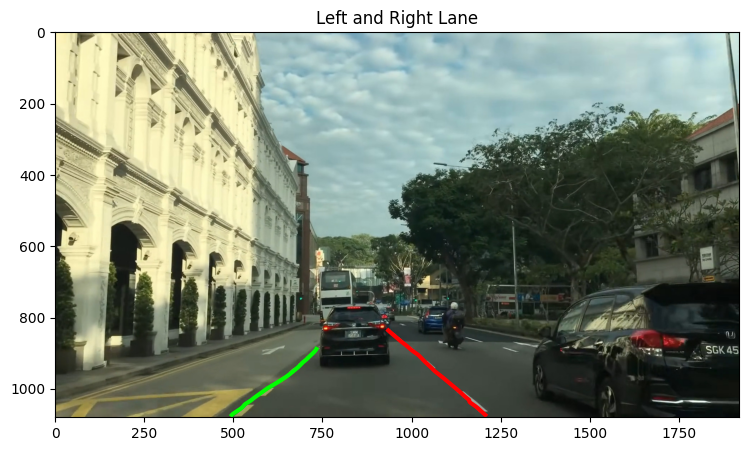

In [24]:
left = min((angle, lane) for angle, lane in splines.items() if angle < 0)[1]
right = max((angle, lane) for angle, lane in splines.items() if angle > 0)[1]

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.plot(left[1], left[2], linewidth=3, color="#00ff00")
plt.plot(right[1], right[2], linewidth=3, color="#ff0000")
plt.title("Left and Right Lane")
plt.show()

## Identifying next vehicle in current lane
Combines object detection and lane information to identify vehicles within the current driving lane. For each detected car, checks if its center x-coordinate falls between the left and right lane boundaries at its y-position. Finds the closest vehicle (highest y-coordinate) within the lane for potential collision avoidance.

Next vehicle in lane: Car #1 at [739.99615 762.30164 942.07635 938.08905]


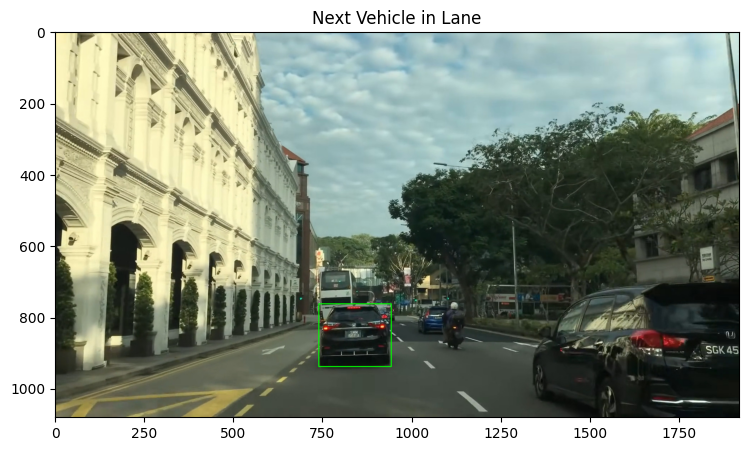

In [25]:
found = False
if len(detections) > 0:
    cars = []
    for i, (label, box) in enumerate(zip(detections["labels"], detections["boxes"])):
        if object_detector.config.id2label[label.item()] == "car":
            x = (box[0] + box[2]).item() // 2  # XyXy, box[0] is x1, box[2] is x2
            y = box[3].item()  # xyxY, box[3] is y2
            cars.append((i, x, y, box))

    for i, x, y, box in sorted(cars, key=lambda c: c[2], reverse=True):
        if left[0](y) <= x and x <= right[0](y):
            print(f"Next vehicle in lane: Car #{i} at {box.numpy()}")
            annotated = img_orig.copy()
            box = box.cpu().numpy().astype(int)
            annotated = cv2.rectangle(
                annotated, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2
            )
            plt.figure(figsize=(10, 5))
            plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
            plt.title("Next Vehicle in Lane")
            plt.show()
            found = True
            break

if not found:
    print("No vehicles found in lane")